In [1]:
import h5py, sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
sys.path.append('/mnt/cbis/home/benedikt/.local/dragonfly/utils/py_src')

In [3]:
import writeemc
import detector
import reademc

In [4]:
path_to_data = "../../data/sparse/" # scratch/sparse on Maxwell
path_to_aux = "../../data/aux/" # scratch/benedikt/aux on Maxwell
path_to_geometry = "../../geometry/"
path_to_recons = "../../data/recons/"

## Reading 2D EMC classes (round 0)

In [5]:
emc_folder = path_to_recons + "melv_0001/"
emc_output = emc_folder + "data/r0/output_040.h5"
emc_photons = emc_folder + 'photons.txt'
emc_detector = path_to_recons + "det/det_lowq6.h5"

In [6]:
photons_list = list(np.loadtxt(emc_photons, dtype=str))
photons_list = [emc_folder + p for p in photons_list]

In [7]:
det = detector.Detector(emc_detector, mask_flag=True)
emc = reademc.EMCReader(photons_list, det)

Parsing HDF5 detector file


Reading ../../data/recons/det/det_lowq6.h5...with mask...done


In [8]:
with h5py.File(emc_detector, "r") as f:
    mask = f['mask'][:].reshape((4,128,128))

In [10]:
with h5py.File(emc_output,'r') as f:
    occupancies = f['occupancies'][:]
    likelihood = f['likelihood'][:]
    orientations = f['orientations'][:]
    images = f['intens'][:]

In [11]:
modes = orientations % occupancies.shape[1]
ndata = len(modes)

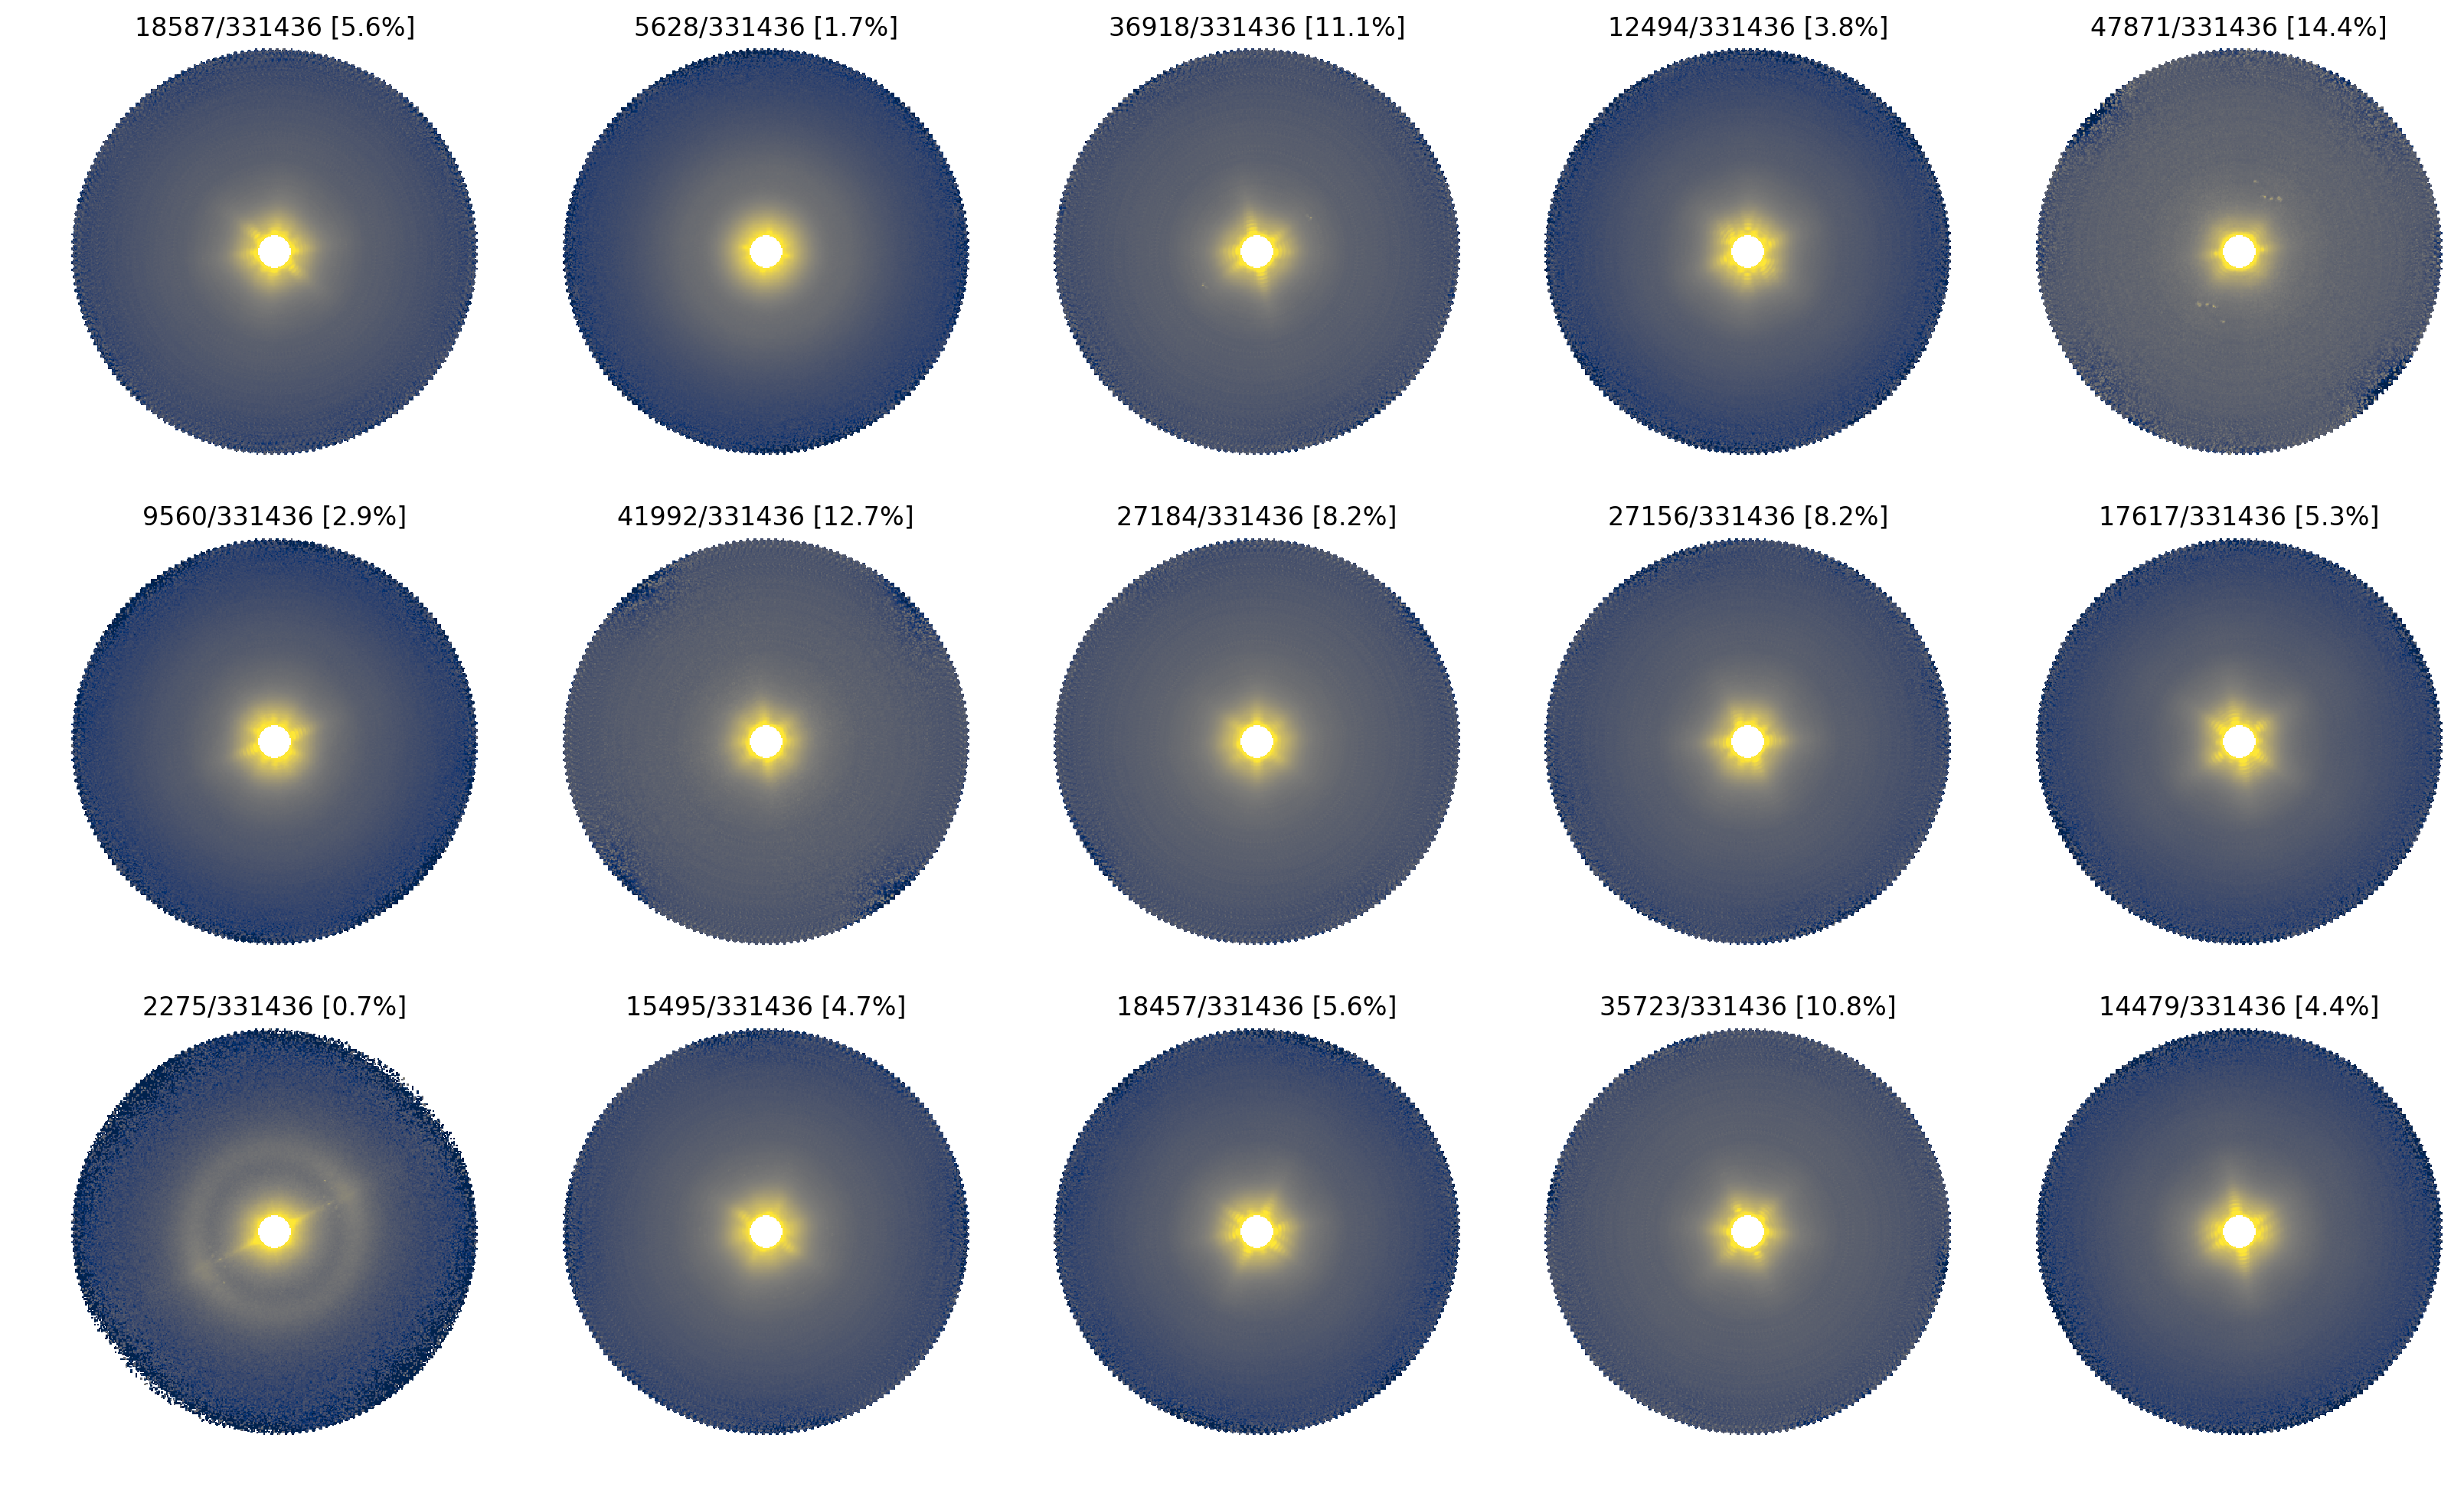

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,12), dpi=200)
for i in range(15):
    c,r = i//5, i%5
    axes[c,r].axis('off')
    nclass = (modes==i).sum()
    axes[c,r].set_title("%d/%d [%.1f%%]" %(nclass,ndata, nclass/ndata*100.))
    axes[c,r].imshow(images[i], norm=colors.LogNorm(vmin=0.0001, vmax=3), cmap='cividis')
plt.savefig("../../plots/2dclasses.png", bbox_inches='tight')
plt.show()

## Check for bad pixels

In [53]:
m = 14
view_index = np.where((modes == m) & (~blacklist.astype(np.bool)))[0]
print(len(view_index))
views_assembled = np.array([emc.get_frame(i) for i in view_index])
views_modules = np.array([emc.get_frame(i, raw=True) for i in view_index])
views_modules = views_modules.reshape((-1,4,128,128))

5250


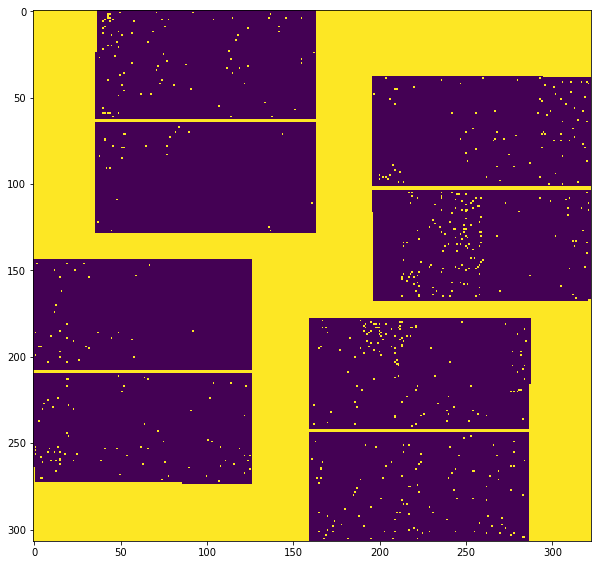

In [56]:
plt.figure(figsize=(10,10))
plt.imshow((views_assembled.std(axis=0) == 0) & (det.mask==1))
plt.show()

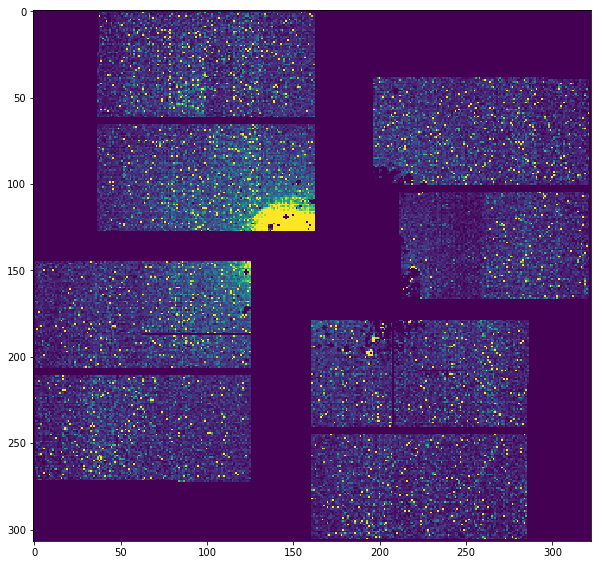

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(views_assembled.sum(axis=0) * (det.mask==1), vmax=50)
plt.show()

In [24]:
powder_std = views_modules.std(axis=0)
powder_sum = views_modules.sum(axis=0)

In [25]:
new_mask = mask.copy()
new_mask[powder_std == 0] = 2

In [28]:
new_detector = path_to_recons + "det/det_lowq9.h5"
os.system("cp %s %s" %(emc_detector, new_detector))
with h5py.File(new_detector, "a") as f:
    f['mask'][:] = new_mask.ravel()

In [6]:
with h5py.File(path_to_recons + "det/det_lowq6.h5", "r") as f:
    mask6 = f['mask'][:].reshape((4,128,128))

In [29]:
with h5py.File(path_to_recons + "det/det_lowq8.h5", "r") as f:
    mask8 = f['mask'][:].reshape((4,128,128))

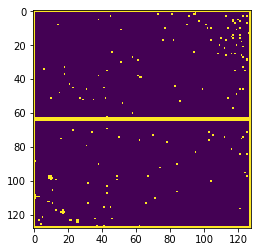

In [30]:
plt.imshow(mask8[1])

## Add bad classes into the blacklist

In [9]:
remove = 2,6,11,15,17,22,30,38,39,45,46,48,49

In [ ]:
blacklist = np.zeros(occupancies.shape[0], dtype=int)
for m in remove:
    blacklist[np.where(modes == m)[0]] = 1
ndata = blacklist.shape[0] - blacklist.sum()

In [ ]:
np.savetxt(path_to_data + "lowq/lacklist_1_%d.dat" %(ndata), blacklist, fmt='%d')